In [1]:
%load_ext autoreload
%autoreload 2

import torchvision
import torch

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from itertools import islice

import training


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
data_path = "./data/"


cuda:0


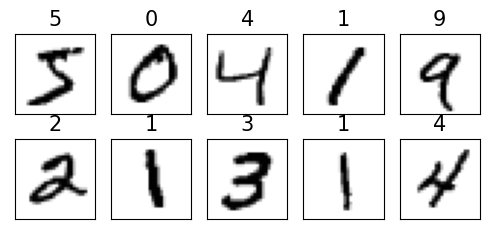

In [3]:
mnist_dataset = torchvision.datasets.MNIST(
    data_path, train=True, download=True)

fig = plt.figure(figsize=(6, 2.5))

for i, (image, label) in islice(enumerate(mnist_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)


In [42]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=False, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=False, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=False, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]


train_loader = DataLoader(_train, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(_valid, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = DataLoader(_test, batch_size=batch_size, shuffle=False, num_workers=16)

# mnist_loaders = {
#     "train": DataLoader(_train, batch_size=batch_size, shuffle=True),
#     "valid": DataLoader(_valid, batch_size=batch_size, shuffle=False),
#     "test": DataLoader(_test, batch_size=batch_size, shuffle=False),
# }

print(
    f"Samples\nTrain: {len(_train)}\nValid: {len(_valid)}\nTest:  {len(_test)}")


Samples
Train: 50000
Valid: 10000
Test:  10000


In [43]:
class FlattenModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(FlattenModel, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)


In [44]:
model = FlattenModel(nn.Linear(28*28, 512),
                     nn.ReLU(),
                     nn.Linear(512, 256),
                     nn.ReLU(),
                     nn.Linear(256, 128),
                     nn.ReLU(),
                     nn.Linear(128, 10),
                    )

model = model.to(device)

model

FlattenModel(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [45]:
training.test_model(test_loader, model)

Test Error: Accuracy: 8.86%, Avg loss: 2.307819


In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
history = training.train_loop(train_loader, model, optimizer=optimizer, val_dataloader=val_loader, num_epochs=15, verbose=True)


Epoch 1/15
Train loss: 0.026072, accuracy: 99.34%
Validation loss:  0.142097, accuracy: 97.77%
-----------------------------
Epoch 2/15
Train loss: 0.010468, accuracy: 99.68%
Validation loss:  0.160363, accuracy: 97.88%
-----------------------------
Epoch 3/15
Train loss: 0.006468, accuracy: 99.78%
Validation loss:  0.174410, accuracy: 97.91%
-----------------------------
Epoch 4/15
Train loss: 0.004456, accuracy: 99.86%
Validation loss:  0.185271, accuracy: 97.93%
-----------------------------
Epoch 5/15
Train loss: 0.003560, accuracy: 99.88%
Validation loss:  0.199223, accuracy: 97.92%
-----------------------------
Epoch 6/15
Train loss: 0.002800, accuracy: 99.90%
Validation loss:  0.211943, accuracy: 97.92%
-----------------------------
Epoch 7/15
Train loss: 0.002881, accuracy: 99.91%
Validation loss:  0.222987, accuracy: 97.94%
-----------------------------
Epoch 8/15
Train loss: 0.002325, accuracy: 99.91%
Validation loss:  0.225323, accuracy: 97.92%
-----------------------------


In [48]:
training.test_model(test_loader, model)

Test Error: Accuracy: 98.12%, Avg loss: 0.314670


In [49]:
class ConvModel(nn.Module):
    def __init__(self, conv_layers, linear_layers):
        super(ConvModel, self).__init__()
        self.conv_layers = conv_layers
        self.linear_layers = linear_layers

    def forward(self, X):
        X = self.conv_layers.forward(X)
        X = X.view(X.size(0), -1)
        return self.linear_layers.forward(X)

In [54]:
cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
        )

linear_layers = nn.Sequential(
            nn.Linear(7 * 7 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

model = ConvModel(cnn_layers, linear_layers)
model = model.to(device)
model

ConvModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
history = training.train_loop(train_loader, model, optimizer=optimizer, val_dataloader=val_loader, num_epochs=40, verbose=True)

Epoch 1/40
Train loss: 0.366753, accuracy: 89.79%
Validation loss:  0.132296, accuracy: 96.09%
-----------------------------
Epoch 2/40
Train loss: 0.111001, accuracy: 96.74%
Validation loss:  0.094270, accuracy: 97.34%
-----------------------------
Epoch 3/40
Train loss: 0.080911, accuracy: 97.56%
Validation loss:  0.070074, accuracy: 97.90%
-----------------------------
Epoch 4/40
Train loss: 0.064999, accuracy: 98.01%
Validation loss:  0.067011, accuracy: 98.10%
-----------------------------
Epoch 5/40
Train loss: 0.054533, accuracy: 98.29%
Validation loss:  0.055886, accuracy: 98.33%
-----------------------------
Epoch 6/40
Train loss: 0.048595, accuracy: 98.49%
Validation loss:  0.059491, accuracy: 98.22%
-----------------------------
Epoch 7/40
Train loss: 0.040963, accuracy: 98.76%
Validation loss:  0.054326, accuracy: 98.39%
-----------------------------
Epoch 8/40
Train loss: 0.036235, accuracy: 98.89%
Validation loss:  0.068153, accuracy: 98.08%
-----------------------------


In [56]:
training.test_model(test_loader, model)

Test Error: Accuracy: 98.91%, Avg loss: 0.053724


In [57]:
cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
        )

linear_layers = nn.Sequential(
            nn.Linear(7 * 7 * 32, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

model = ConvModel(cnn_layers, linear_layers)

model = model.to(device)
model

ConvModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
history = training.train_loop(train_loader, model, optimizer=optimizer, val_dataloader=val_loader, num_epochs=40, verbose=True)

Epoch 1/40
Train loss: 1.718302, accuracy: 77.19%
Validation loss:  1.554055, accuracy: 92.19%
-----------------------------
Epoch 2/40
Train loss: 1.536077, accuracy: 93.47%
Validation loss:  1.504347, accuracy: 96.21%
-----------------------------
Epoch 3/40
Train loss: 1.507905, accuracy: 95.96%
Validation loss:  1.493205, accuracy: 97.28%
-----------------------------
Epoch 4/40
Train loss: 1.497701, accuracy: 96.77%
Validation loss:  1.488826, accuracy: 97.46%
-----------------------------
Epoch 5/40
Train loss: 1.492841, accuracy: 97.25%
Validation loss:  1.483138, accuracy: 98.00%
-----------------------------
Epoch 6/40
Train loss: 1.488792, accuracy: 97.59%
Validation loss:  1.482754, accuracy: 98.02%
-----------------------------
Epoch 7/40
Train loss: 1.486338, accuracy: 97.76%
Validation loss:  1.483497, accuracy: 97.88%
-----------------------------
Epoch 8/40
Train loss: 1.484986, accuracy: 97.86%
Validation loss:  1.479950, accuracy: 98.19%
-----------------------------


In [59]:
training.test_model(test_loader, model)

Test Error: Accuracy: 98.96%, Avg loss: 1.471821


In [71]:
def plot_history(history: dict):
    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(history['train_loss'], lw=3)
    plt.plot(history['val_loss'], lw=3)
    plt.legend(['Train loss', 'Validation loss'], fontsize=10)
    ax.set_xlabel('Epochs', size=15)
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], lw=3)
    plt.plot(history['val_accuracy'], lw=3)
    plt.legend(['Train acc.', 'Validation acc.'], fontsize=10)
    ax.set_xlabel('Epochs', size=10)


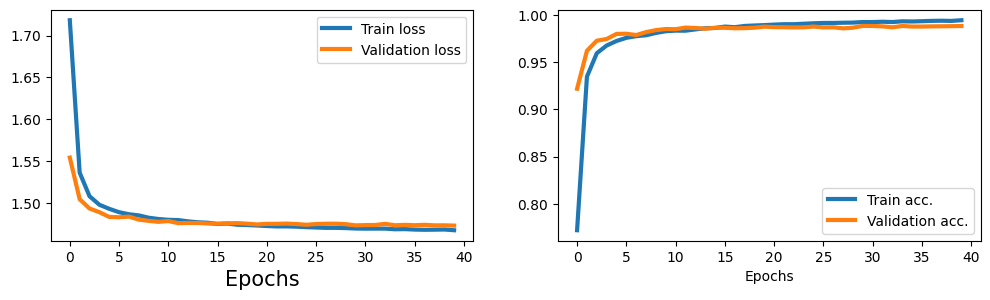

In [72]:
plot_history(history)